### Energy-based models assignment; implementation problem

This is a (hopefully short) implementation problem of the third assignment. We will investigate convolutional auto-encoders and denoising convolutional auto-encoders.

**SOLUTION NOTE**:
- To run it yourself, the paths in this colab need to be replaced.
- This is only one implementation. Many other solutions are also acceptable.
- Take note of the other "solution notes" below.

### Prereqs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




**Question 1 (of this notebook):**

We first load the data.

TODO: print out a few shapes. See comments in the below cell.

In [ ]:
import datetime
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import sys

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.utils import data
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms


def load_fashion_mnist(batch_size=64):
    # One convention (of the many) is to use a real number between -1 and 1
    # (inclusive) to represent each pixel; instead of an integer from 0 to 255.
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

    train_dataset = datasets.FashionMNIST(root='./data', train=True,
                                          download=True, transform=transform)

    # Create validation set from training set, given that torchvision only gives
    # us the train/test split.  
    num_train = len(train_dataset)
    indices = list(range(num_train))
    valid_size = 0.1
    split = int(np.floor(valid_size * num_train))

    random_seed = 123
    np.random.seed(random_seed)  # think: why do we do this?
    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = data.SubsetRandomSampler(train_idx)
    valid_sampler = data.SubsetRandomSampler(valid_idx)
    train_loader = data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=valid_sampler)
    test_dataset = datasets.FashionMNIST(root='./data', train=False,
                                         download=True, transform=transform)
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size,
                                  shuffle=False)
    
    # TODO: the images in training, validation, and test sets have shape:
    # [num of examples, image height, image weight];
    # write a few lines of code to print out the three (train/val/test) shapes;
    # for example, the test set image shape should be [10000, 28, 28];
    # try exploring the dataset using test_dataset[7], test_dataset.data, etc.
    print(train_dataset.data[train_idx].shape)
    print(train_dataset.data[valid_idx].shape)
    print(test_dataset.data.shape)

    return train_loader, valid_loader, test_loader

def imshow(img):
    # First unnormalize if we want to print out the image. We're using the
    # convention that each image pixel is between -1 and 1. But when python
    # prints out images, the pixel needs to be between 0 and 1.
    img = img / 2 + 0.5
    img_numpy = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(img_numpy, (1, 2, 0)))

In [ ]:
batch_size = 64
train_loader, valid_loader, test_loader = load_fashion_mnist(batch_size)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([54000, 28, 28])
torch.Size([6000, 28, 28])
torch.Size([10000, 28, 28])


In [ ]:
!nvidia-smi  # make sure you're using GPUs when you are about to train the model

Wed Oct 28 02:30:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

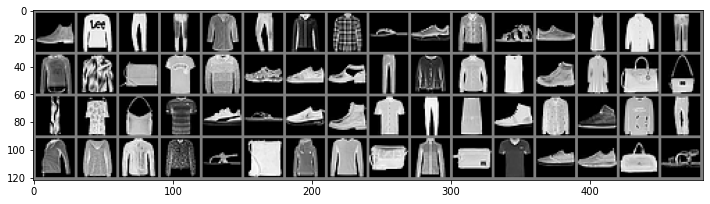

In [ ]:
# Taking a look at what the images are like
images = next(iter(test_loader))[0][:64]
imshow(torchvision.utils.make_grid(images, nrow=16))

In [ ]:
images.shape

torch.Size([64, 1, 28, 28])

Check out the ten classes on page 3: https://arxiv.org/pdf/1708.07747.pdf
- 0: t-shirt/top; 1: trouser; 2: pullover; 3: dress; 4: coat; 5: sandals; 6: shirt; 7: sneaker; 8: bag; 9: ankle boots.

<!-- For CIFAR10, check out the ten classes here: https://www.cs.toronto.edu/~kriz/cifar.html
- Airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck -->

This dataset is much more difficult on the classification task, compared to the digit MNIST which we saw in Lab 2. However, **today we will NOT be doing classification!!! So let's assume that the labels DO NOT EXIST in the iterators (the data loaders)!**

### Model

Next, we will implement two versions of autoencoders: (1) convolutional autoencoder; (2) denoising convolutional autoencoder (but actually we'll be using the same model code).

**Question 2: implement a convolutional autoencoder**

TODO
- In CAE class below, complete the init function and the forward function, such that your implementation satisfies the following requirements.
  - The output image dimension (from the forward function) is exactly the same as the input image dimension. 
  - There are two Conv2d layer in the encoder; there are three Conv2d or ConvTranspose2d blocks in the decoder. The out_channel for the second convolutional layer in the encoder should be >= 16.
    - Use ReLU or some other nonlinearities, followed by pooling, after each convolution layer in the encoder. 
    - Use ReLU or some other nonlinearities, after each convolution layer in the decoder (except for the very last convolution layer). 
    - Add batch normalization layers after the nonlinearities, just like what you may have done in the previous homework. 
    - In decoder, if you want to obtain an output feature map with size larger than size of input feature map, consider using ConvTranspose2d, or UpsamplingBilinear2d, after figuring out what they do.
    - No hard requirement on what padding or stride to use, but make sure they're small, given that our image is only 28*28. 
  - Note that your parameters (e.g., number of filters in the intermediate layers) should not be too big, given that our image is greyscale and has 28*28 pixels only.



In [ ]:
# One good solution

cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()

        self.encoder_conv1 = nn.Conv2d(1, 16, 3, padding=1) 
        self.encoder_conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.decoder_conv1 = nn.ConvTranspose2d(32, 16, 3, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(16, 8, 3, padding=1)
        self.decoder_conv3 = nn.ConvTranspose2d(8, 1, 3, padding=1)

        self.batch_norm_e1 = nn.BatchNorm2d(num_features = 16)
        self.batch_norm_e2 = nn.BatchNorm2d(num_features = 32)
        self.batch_norm_d1 = nn.BatchNorm2d(num_features = 16)
        self.batch_norm_d2 = nn.BatchNorm2d(num_features = 8)

        self.maxpool2d = nn.MaxPool2d(2)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, y):
        """Forward function of CAE class.

        Args:
          y: a batch of input images.
        
        Returns:
          yhat: the batch of reconstructed images.
        """

        z = self.relu(self.encoder_conv1(y))
        z = self.batch_norm_e1(z)
        z = self.maxpool2d(z)

        z = self.relu(self.encoder_conv2(z))
        z = self.batch_norm_e2(z)
        z = self.maxpool2d(z)

        z = self.relu(self.decoder_conv1(z))
        z = self.batch_norm_d1(z)
        z = self.upsample(z)
        
        z = self.relu(self.decoder_conv2(z))
        z = self.batch_norm_d2(z)
        z = self.upsample(z)

        yhat = self.decoder_conv3(z)
        return yhat



In [ ]:
# Another good answer

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        

        self.encoder = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(16),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.MaxPool2d(kernel_size=2) 
        )
        
        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
          nn.ReLU(),
          nn.BatchNorm2d(16),
          nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        )


    def forward(self, y):
        """Forward function of CAE class.

        Args:
          y: a batch of input images.
        
        Returns:
          yhat: the batch of reconstructed images.
        """
        encoded = self.encoder(y)
        decoded = self.decoder(encoded)
        return decoded


**Question 3: complete the train() and validate() function to be used later**

TODO
- Complete the train() function.
  - Hint: recall the five steps we discussed in Lab 2.
  - Make sure your images are on GPUs (device cuda) before you train. Otherwise, your training may be extremely extremely slow and it may take you 50 times longer than other people.

- Complete the validate() function:
  - The only thing we need to do is to save the model when we achieve the best validation loss so far. So, check out the pytorch documentation or the third lab, for how to save checkpoints. Make sure to do this step because we need to load the model later.

In [ ]:
def add_noise(images):
    noise = torch.mul(
        torch.randn(images.shape),
        torch.rand(images.shape[0]).view(-1, 1, 1, 1))
    images_noisy = images + noise
    images_noisy = torch.clamp(images_noisy, -1.0, 1.0)
    return images_noisy

In [ ]:
torch.rand(images.shape[0]).view(-1, 1, 1, 1).shape

torch.Size([64, 1, 1, 1])

In [ ]:
def train(autoencoder, train_loader, epoch, num_epoch, learning_rate,
          weight_decay, log_interval, denoising=False):
    # Using sum reduction simply bc otherwise, the scale of the loss is too small;
    # given that we always have 28*28 images, using sum/mean reduction wouldn't
    # make a difference.
    criteria = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(
        autoencoder.parameters(), lr=learning_rate)

    autoencoder.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        images, _ = data
        if denoising:
            input_images = add_noise(images)
        else:
            input_images = images
        if cuda:
            input_images = input_images.to(device)
            images = images.to(device)
        outputs = autoencoder(input_images)
        mse_loss = criteria(outputs, images)
        loss = mse_loss
        loss.backward()
        optimizer.step()
        if (i + 1) % log_interval == 0:
            print('Epoch [{}/{}] - Iter[{}/{}], MSE loss:{:.6f}'.format(
                epoch + 1, num_epoch, i + 1,
                len(train_loader.dataset) // batch_size, loss.item() / batch_size
            ))


def validate(autoencoder, valid_loader, best_val_loss, denoising=False):
    total_loss = 0
    criteria = nn.MSELoss(reduction='sum')
    autoencoder.eval()
    for i, data in enumerate(valid_loader):
        images, _ = data
        if denoising:
            input_images = add_noise(images)
        else:
            input_images = images
        if cuda:
            input_images = input_images.to(device)
            images = images.to(device)
        outputs = autoencoder(input_images)
        loss = criteria(outputs, images)
        total_loss += loss
    avg_loss = total_loss / (len(valid_loader) * batch_size)

    print('\nLoss per batch on validation set: {:.6f}'.format(avg_loss))

    if avg_loss < best_val_loss:
        if denoising:
            save_path = '/content/drive/My Drive/colabs/prep-dl-fall20-hw3/checkpoint/conv_autoencoder_new_denoising.pt'
        else:
            save_path = '/content/drive/My Drive/colabs/prep-dl-fall20-hw3/checkpoint/conv_autoencoder_new_0.pt'
        best_val_loss = avg_loss
        # torch.save(autoencoder.state_dict(), save_path)
        print('Saved best model in the checkpoint directory\n')
    
    return best_val_loss

def evaluate(autoencoder, test_loader, denoising=False):
    total_loss = 0
    criteria = nn.MSELoss(reduction='sum')
    autoencoder.eval()
    for i, data in enumerate(test_loader):
        images, _ = data
        if denoising:
            input_images = add_noise(images)
        else:
            input_images = images
        if cuda:
            input_images = input_images.to(device)
            images = images.to(device)
        outputs = autoencoder(input_images)
        loss = criteria(outputs, images)
        total_loss += loss
    avg_loss = total_loss / (len(test_loader) * batch_size)

    print('\nMSE loss per batch on test set: {:.6f}'.format(avg_loss))


**Question 4: implement a denoising convolutional autoencoder**

The input to a denoising CAE is a perturbed image, and the output is the original image. Given that we're using the same network, there's nothing we need to change about the CAE class. 

TODO
- However, add an argument called ```denoising``` (defaulted to be ```False```) in the train() to indicate if our input will be the noisy version (in this case ```denoising=True```) or a clean version (in this case ```denoising=False```), and modify the functions appropriately, with the following instructions. Do the same for validate() and evaluate() to decide if we want to validate/evaluate on noisy or clean images.

- Perturbation (i.e., making images noisy)
  - First make sure that each pixels are represented by a real number from -1 to 1 (instead of integers from 0 to 255). The pixel should be already from -1 to 1, unless you did something you shouldn't have done. 
  - Next, do a perturbation to each image according to the following distribution: the standard Gaussian distribution multiplied by a number uniformly sampled from 0 to 1.
    - In other words, the distribution is a Gaussian distribution with different standard deviation for each image. Hint: Each pixel in image i should be perturbed according to a Gaussian distribution with standard deviation $\sigma_i$, and each pixel in image j should be perturbed according to a Gaussian distribution with standard deviation $\sigma_j$. 
    - Make sure that the resulting perturbed/noisy image are still represented by numbers from -1 to 1 (so you may need to do some clipping with min -1 and max 1). 

- Note: feel free to use a helper function (for example, add_noise()) outside the train(), validate(), evaluate() functions.

**Question 5: Training**

TODO

- Now, train your CAE model, and train your denoising CAE model. You can set a patience counter on your own (similar to homework 2), meaning if validation loss doesn't decrease for, say, 10 epochs (just an example), then you can stop training. Each training procedure may take half an hour or an hour. It may take many many more hours if you didn't move the model or the data onto GPUs. Moreover, to make sure your training is not lost in case colab disconnects, it's important to save checkpoints! Make sure you wrote the checkpoint saving code in the validate function.
- Report the best validation loss. No need to plot the curve, but you can plot it nevertheless to have a better understanding on your training process.

In [ ]:
batch_size = 64
best_val_loss = float('inf')
num_epoch = 100
learning_rate = 1e-3
log_interval = 100
weight_decay = None

denoising = True
keep_training_from_ckpt = False

if denoising:
    load_path = '/content/drive/My Drive/colabs/prep-dl-fall20-hw3/checkpoint/conv_autoencoder_new_denoising.pt'
else:
    load_path = '/content/drive/My Drive/colabs/prep-dl-fall20-hw3/checkpoint/conv_autoencoder_new_0.pt'

conv_autoencoder = CAE()
if cuda:
    conv_autoencoder.to(device)

if keep_training_from_ckpt:
    conv_autoencoder.load_state_dict(torch.load(load_path))
for epoch in range(num_epoch):
    start_time = datetime.datetime.now()
    train(conv_autoencoder, train_loader, epoch, num_epoch, learning_rate,
          weight_decay, log_interval, denoising)
    end_time = datetime.datetime.now()
    print(f'Trained this epoch using {(end_time - start_time).seconds} seconds')
    # validate and save model if it's the best model so far
    best_val_loss = validate(conv_autoencoder, valid_loader, best_val_loss,
                             denoising)
print('Training done; best validation loss {:.4f}'.format(best_val_loss))

Epoch [1/100] - Iter[100/937], MSE loss:60.614731
Epoch [1/100] - Iter[200/937], MSE loss:56.313675
Epoch [1/100] - Iter[300/937], MSE loss:49.730534
Epoch [1/100] - Iter[400/937], MSE loss:49.842171
Epoch [1/100] - Iter[500/937], MSE loss:43.354897
Epoch [1/100] - Iter[600/937], MSE loss:45.647717
Epoch [1/100] - Iter[700/937], MSE loss:44.256210
Epoch [1/100] - Iter[800/937], MSE loss:44.693565
Trained this epoch using 11 seconds

Loss per batch on validation set: 39.491554
Saved best model in the checkpoint directory

Epoch [2/100] - Iter[100/937], MSE loss:40.540279
Epoch [2/100] - Iter[200/937], MSE loss:44.112843
Epoch [2/100] - Iter[300/937], MSE loss:34.756439


KeyboardInterrupt: ignored

**Question 6: evaluate on test sets**

Only run the below cell when you're done with training, and you're evaluating on test sets.

TODO:
- Print out the reconstruction loss on test set for both the CAE and denoising CAE models.
- Print out a few reconstructed images (for both models). It's perfectly fine if your reconstructed images are blurry. If your reconstructed image is extremely bad (for example, if you absolutely can't tell what object it is anymore), then you probably made a mistake in the previous steps. You might have chosen an overly small out_channel, for example. Or, learning might be inadequate. Or, you made a mistake in model saving / model loading.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



MSE loss per batch on test set: 38.707397


<Figure size 432x288 with 0 Axes>

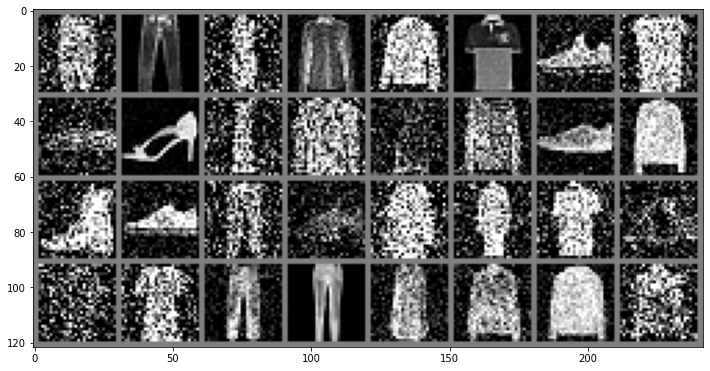

<Figure size 432x288 with 0 Axes>

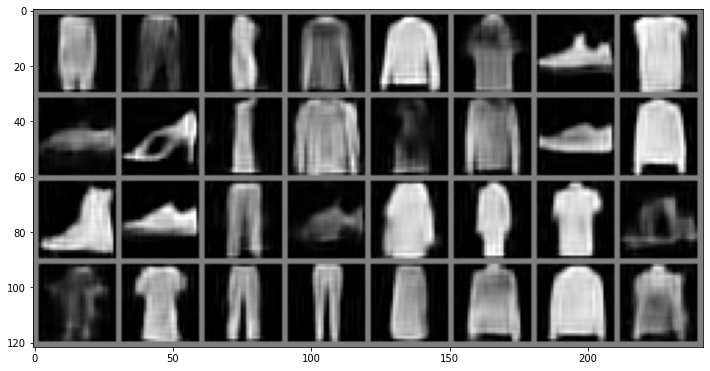

In [ ]:
# Only run at evaluation time!

conv_autoencoder = CAE()

denoising = True

if denoising:
    conv_autoencoder.load_state_dict(torch.load('/content/drive/My Drive/colabs/prep-dl-fall20-hw3/checkpoint/conv_autoencoder_new_denoising.pt'))
else:
    conv_autoencoder.load_state_dict(torch.load('/content/drive/My Drive/colabs/prep-dl-fall20-hw3/checkpoint/conv_autoencoder_new_0.pt'))
if cuda:
    conv_autoencoder.cuda()
evaluate(conv_autoencoder, test_loader, denoising)

conv_autoencoder.cpu()
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = images[:32]
if denoising:
    images_noisy = add_noise(images)
else:
    images_noisy = images
outputs = conv_autoencoder(images_noisy)

plt.figure()
imshow(torchvision.utils.make_grid(images_noisy.data))
plt.figure()
imshow(torchvision.utils.make_grid(outputs.data))


**SOLUTION NOTE**: The solution above only covers the denoising CAE case. For regular CAE, do the same except with ``denoising=False```.
- In the regular case, the input should be clean, the output should be clean (although might be a little smoother).
- In the denoising CAE case, the input should be noisy (shown above), and the output should be clean (although might be a little smoother; the quality might be a bit worse than the reconstructions from the regular CAE).

**Question 7: plot loss vs. noise length**

TODO:
For both CAE and denoising CAE models you trained, plot loss vs. noise length, for five different images in five separate plots.
- Terminology
  - The noise length is the L2 norm of the noise you added to the image. So, it will be the norm of image_noisy minus image. 
  - The loss refers to the reconstruction loss.

- For each image...
  - The input to both CAE and denoising CAE should be noisy images. But how much noise?
  - For each image, at least add 100 different noises with different length. Perhaps you can use different standard deviations in the Gaussian distribution (when you add the noise into the images).
  - Compute the reconstruction loss for each noise you added. 
  - Now you would have the following list [(noise length #1, loss #1), (noise length #2, loss #2), ..., (noise length #n, loss #n)] (where n is at least 100) for CAE. You should have a similar list for denoising CAE. Now plot the loss (vertical axis) and length (horizontal axis), of two models, in the same plot. But the plot only corresponds to one original clean image.

- Do the above for 5 different images.


In [ ]:
def add_noise_coeff(images, coeff):
    noise = torch.mul(
        torch.randn(images.shape),
        torch.tensor([coeff]).view(-1, 1, 1, 1))
    images_noisy = images + noise
    images_noisy = torch.clamp(images_noisy, -1.0, 1.0)
    return images_noisy

In [ ]:
# Plot loss vs. length

denoising = False

loss_cae = []
length_cae = []
loss_dcae = []
length_dcae = []

def get_length_and_loss(denoising):
    loss_ae = []
    length_ae = []
    autoencoder = CAE()

    if denoising:
        autoencoder.load_state_dict(torch.load('/content/drive/My Drive/colabs/prep-dl-fall20-hw3/checkpoint/conv_autoencoder_new_denoising.pt'))
    else:
        autoencoder.load_state_dict(torch.load('/content/drive/My Drive/colabs/prep-dl-fall20-hw3/checkpoint/conv_autoencoder_new_0.pt'))
    if cuda:
        autoencoder.cuda()

    total_loss = 0
    criteria = nn.MSELoss(reduction='none')
    autoencoder.eval()
    for i, data in enumerate(test_loader):
        images, _ = data
        coefficient = 0.0
        while coefficient < 1.5:
            images = images.to('cpu')
            input_images = add_noise_coeff(images, coefficient)
            if cuda:
                input_images = input_images.to(device)
                images = images.to(device)
            for k in range(1):
                length_ae.append(torch.norm((input_images - images)[k]))
            outputs = autoencoder(input_images)
            loss = criteria(outputs, images)
            for k in range(1):
                loss_ae.append(torch.sum(loss[k]))
            coefficient += 0.01

        return loss_ae, length_ae

In [ ]:
loss_cae, length_cae = get_length_and_loss(False)
loss_dcae, length_dcae = get_length_and_loss(True)

In [ ]:
loss_cae = [float(x) for x in loss_cae]
length_cae = [float(x) for x in length_cae]



In [ ]:
loss_dcae = [float(x) for x in loss_dcae]
length_dcae = [float(x) for x in length_dcae]

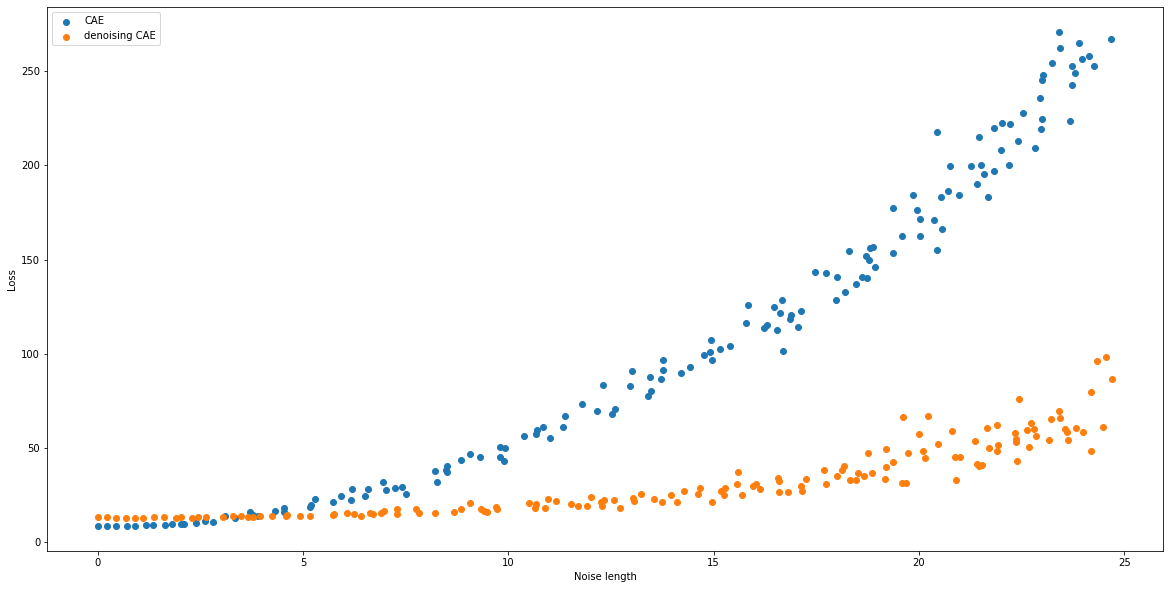

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.scatter(length_cae, loss_cae, label='CAE')
plt.scatter(length_dcae, loss_dcae, label='denoising CAE')
plt.xlabel('Noise length')
plt.ylabel('Loss')
plt.legend()

**SOLUTION NOTE**: Need to repeat the above three times, for three different images. The right end of the blue curve should be higher than the orange curve.

### Visualizing interpolations

**SOLUTION NOTE**
- The below corresponds to Problem 8. 
- The solution below is one way of completing this problem. Another way (which may be more elegant): we can add another function in the CAE class to return certain representations.
- Please see https://campuswire.com/c/GF0B2984E/feed/155 for an interesting discussion. 

In [ ]:
autoencoder = CAE()

autoencoder.load_state_dict(torch.load('/content/drive/My Drive/colabs/prep-dl-fall20-hw3/checkpoint/conv_autoencoder_new_0.pt'))
# autoencoder.load_state_dict(torch.load('/content/drive/My Drive/colabs/prep-dl-fall20-hw3/checkpoint/conv_autoencoder_new_denoising.pt'))

autoencoder.cpu()

autoencoder_weights = autoencoder.state_dict()['encoder_conv1.weight']

torch_scale = lambda x: (x - torch.min(x)) / (torch.max(x) - torch.min(x))
autoencoder_weights_norm = torch_scale(autoencoder_weights)

In [ ]:
def visualize_one_model(model, image_id, image_id2, gamma1):
    model_weights = []
    conv_layers = []

    # counter to keep count of the conv layers
    counter = 0 
    # append all the conv layers and their respective weights to the list
    model_children = list(model.children())
    for i in range(len(model_children)):
        if type(model_children[i]) in [nn.Conv2d, nn.ConvTranspose2d]:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
    print(f"Total convolutional layers: {counter}")
    print("model children: ", model_children)
    relu_layer = model_children[0]
    tanh_layer = model_children[1]
    maxpool_layer = model_children[-2]
    upsample_layer = model_children[-1]
    batchnorm_layer_a = model_children[7]
    batchnorm_layer_b = model_children[8]
    batchnorm_layer_c = model_children[9]
    batchnorm_layer_d = model_children[10]

    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    img = images[image_id].unsqueeze(0)

    img2 = images[image_id2].unsqueeze(0)


    gamma1 = gamma1
    gamma2 = 1-gamma1

    results2 = [batchnorm_layer_a(relu_layer(conv_layers[0](img2)))]
    for i in range(1, 2):
        if i == 1:  # encoder 2 feature map
            results2.append(maxpool_layer(batchnorm_layer_b(relu_layer(conv_layers[1](maxpool_layer(results2[-1]))))))


    # pass the image through all the layers
    results = [batchnorm_layer_a(relu_layer(conv_layers[0](img)))]
    for i in range(1, len(conv_layers)+1):
        if i == 1:  # encoder 2 feature map
            results.append(gamma1 * maxpool_layer(batchnorm_layer_b(relu_layer(conv_layers[1](maxpool_layer(results[-1]))))) + gamma2 * results2[-1])
        elif i == 2:  # decoder 1 feature map
            results.append(batchnorm_layer_c(relu_layer(conv_layers[2](results[-1]))))
        elif i == 3:  # decoder 2 feature map
            results.append(batchnorm_layer_d(relu_layer(conv_layers[3](upsample_layer(results[-1])))))
        elif i == 4:
            results.append(conv_layers[4](upsample_layer(results[-1])))
    outputs = results


    for num_layer in range(len(outputs)-1, len(outputs)):
        plt.figure(figsize=(30, 30))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        print(layer_viz.size())
        for i, filter in enumerate(layer_viz):
            if i == 64: # we will visualize only 8x8 blocks from each layer
                break
            plt.subplot(8, 8, i + 1)
            plt.imshow(filter, cmap='gray')
            plt.axis("off")
        print(f"Layer {num_layer} feature maps below:")
        plt.show()
        plt.close()

k = 0.0
Total convolutional layers: 5
model children:  [ReLU(inplace=True), Tanh(), Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)]
torch.Size([1, 28, 28])
Layer 4 feature maps below:


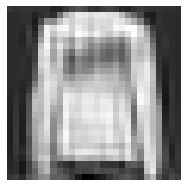

k = 0.1
Total convolutional layers: 5
model children:  [ReLU(inplace=True), Tanh(), Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)]
torch.Size([1, 28, 28])
Layer 4 feature maps below:


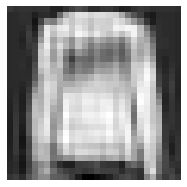

k = 0.2
Total convolutional layers: 5
model children:  [ReLU(inplace=True), Tanh(), Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)]
torch.Size([1, 28, 28])
Layer 4 feature maps below:


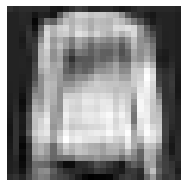

k = 0.30000000000000004
Total convolutional layers: 5
model children:  [ReLU(inplace=True), Tanh(), Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)]
torch.Size([1, 28, 28])
Layer 4 feature maps below:


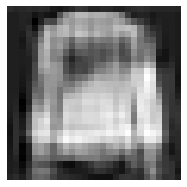

k = 0.4
Total convolutional layers: 5
model children:  [ReLU(inplace=True), Tanh(), Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)]
torch.Size([1, 28, 28])
Layer 4 feature maps below:


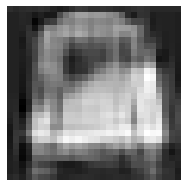

k = 0.5
Total convolutional layers: 5
model children:  [ReLU(inplace=True), Tanh(), Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)]
torch.Size([1, 28, 28])
Layer 4 feature maps below:


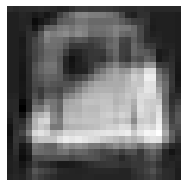

k = 0.6000000000000001
Total convolutional layers: 5
model children:  [ReLU(inplace=True), Tanh(), Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)]
torch.Size([1, 28, 28])
Layer 4 feature maps below:


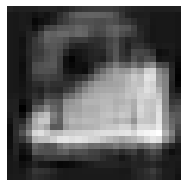

k = 0.7000000000000001
Total convolutional layers: 5
model children:  [ReLU(inplace=True), Tanh(), Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)]
torch.Size([1, 28, 28])
Layer 4 feature maps below:


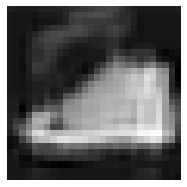

k = 0.8
Total convolutional layers: 5
model children:  [ReLU(inplace=True), Tanh(), Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)]
torch.Size([1, 28, 28])
Layer 4 feature maps below:


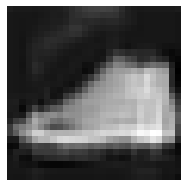

k = 0.9
Total convolutional layers: 5
model children:  [ReLU(inplace=True), Tanh(), Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)]
torch.Size([1, 28, 28])
Layer 4 feature maps below:


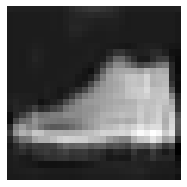

k = 1.0
Total convolutional layers: 5
model children:  [ReLU(inplace=True), Tanh(), Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)]
torch.Size([1, 28, 28])
Layer 4 feature maps below:


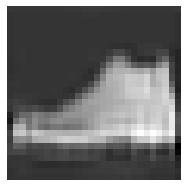

In [ ]:
for k in np.arange(0, 1.01, 0.1):
  print('k =', k)
  visualize_one_model(autoencoder, 0, 1, k)

### BELOW IS NOT PART OF THIS HW.

Total convolutional layers: 5
model children:  [ReLU(inplace=True), Tanh(), Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)]
torch.Size([32, 28, 28])
Layer 0 feature maps below:


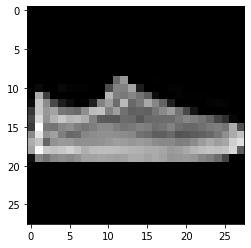

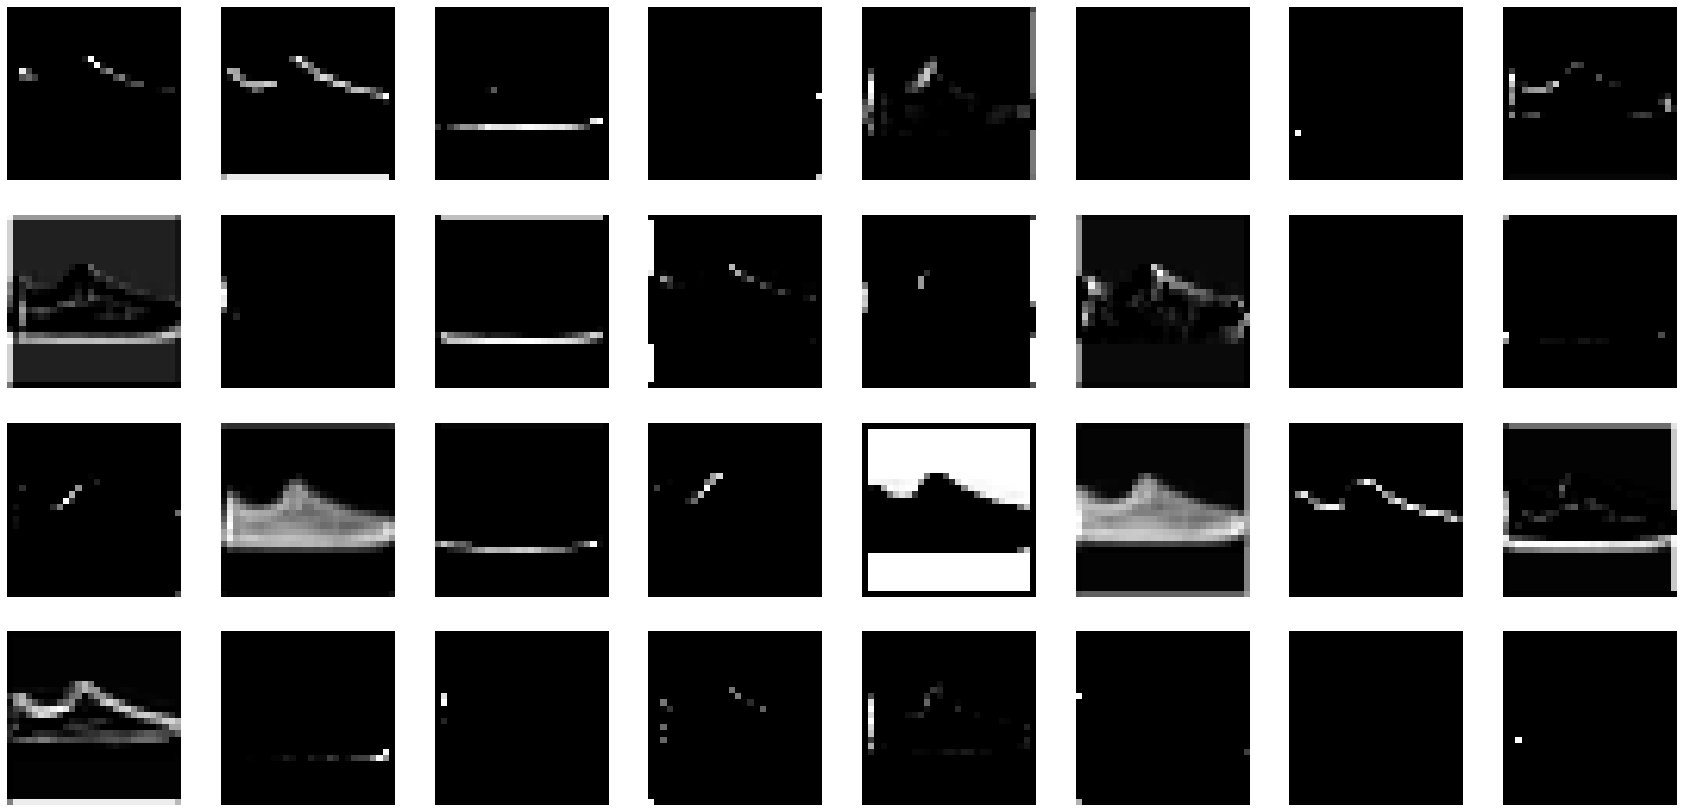

torch.Size([16, 14, 14])
Layer 1 feature maps below:


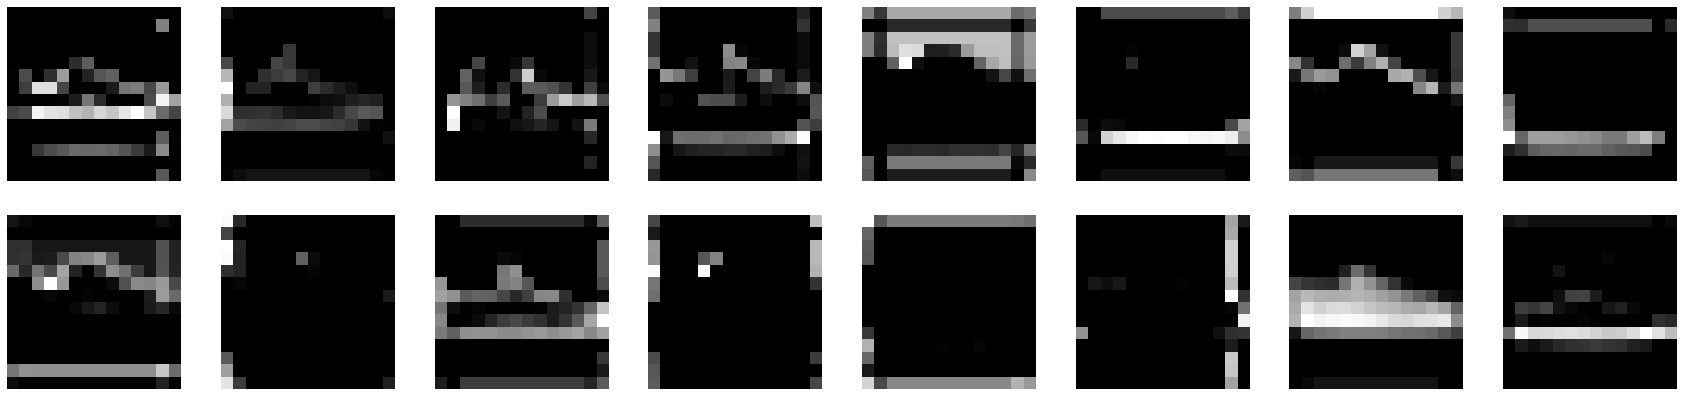

torch.Size([16, 7, 7])
Layer 2 feature maps below:


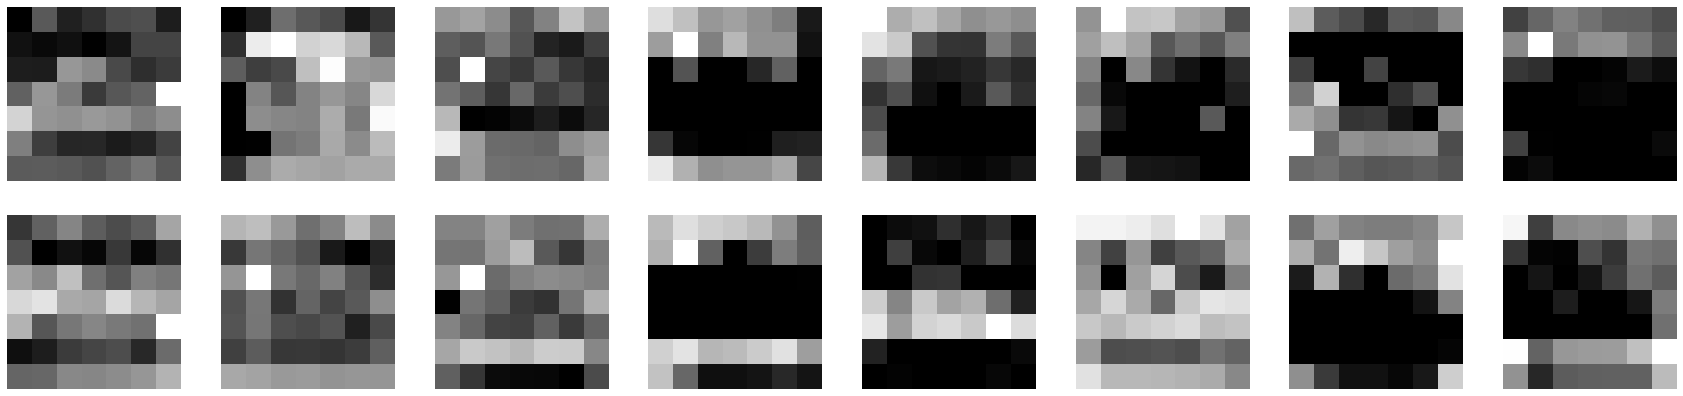

torch.Size([8, 14, 14])
Layer 3 feature maps below:


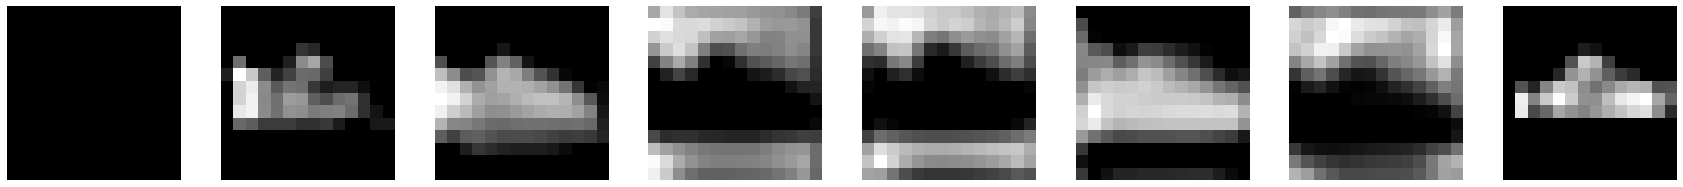

torch.Size([1, 28, 28])
Layer 4 feature maps below:


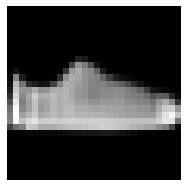

In [ ]:
 visualize_one_model(sparse_autoencoder_l1, 12)